In [60]:
# AlphaGo notebook
import sgf
import numpy as np
from openTSNE import TSNE
from openTSNE.callbacks import ErrorLogger
from sgfmill import boards
from sgfmill import ascii_boards
from sgfmill import sgf_moves
from sgfmill import sgf as sgf2
from matplotlib import pyplot as plt
import os
from scipy import interpolate
import pywt
from scipy.fftpack import fft, ifft, fft2

delete_duplicates = True



class GoBoard:
    def __init__(self):
        # create board as dictionary
        self.board = {}
        self.sgf = boards.Board(19)
        self.moves = []

        
    def encode(self, value):
        #if value == None:
        #    return [ 1, 0, 0 ]
        #if value == 'n':
        #    return [ 1, 0, 0 ]
        #if value == 'b':
        #    return [ 0, 1, 0 ]
        #if value == 'w':
        #    return [ 0, 0, 1 ]
        if value == None:
            return [ 1, 0, 0 ]
        if value == 'n':
            return [ 1, 0, 0 ]
        if value == 'b':
            return [ 0, 0, 1 ]
        if value == 'w':
            return [ 0, 1, 0 ]
        
    def encodeHaar(self, value):
        if value == None:
            return 0
        if value == 'n':
            return 0
        if value == 'b':
            return 1
        if value == 'w':
            return 1
        
        
    def histo(self, value):
        if value == None:
            return 0
        if value == 'n':
            return 0
        if value == 'b':
            return 1
        if value == 'w':
            return 1
        
        
    def toFeatureVector(self):
        vector = []
        for x in range(0, 19):
            for y in range(0, 19):
                key = chr(ord('a') + x) + chr(ord('a') + y)
                col = ord(key[0]) - ord('a')
                row = 18 - (ord(key[1]) - ord('a'))
                if (self.sgf.get(row, col) != None):
                    vector = vector + self.encode(self.sgf.get(row, col))
                else:
                    vector = vector + self.encode('n')
                
                
                #if key in self.board:
                 #   vector = vector + self.encode(self.board[key])
                #else:
                 #   vector = vector + self.encode('n')
        return vector
    
    def toFeatureVectorS(self):
        vec = []
        for x in range(0, 2):
            for y in range(0, 2):
                minX = x * 10
                minY = y * 10
                maxX = min(19, (x + 1) * 10)
                maxY = min(19, (y + 1) * 10)
                
                s = np.array([ 0, 0, 0 ])
                for i in range(minX, maxX):
                    for j in range(minY, maxY):
                        s = s + np.array(self.encode(self.sgf.get(i, j)))
                vec = vec + s.tolist()

        return vec
    
    def wavelet(self):
        vector = np.zeros((19, 19), dtype=np.float64)
        for x in range(0, 19):
            for y in range(0, 19):
                key = chr(ord('a') + x) + chr(ord('a') + y)
                col = ord(key[0]) - ord('a')
                row = 18 - (ord(key[1]) - ord('a'))
                
                if (self.sgf.get(row, col) != None):
                    vector[x, y] = self.encodeHaar(self.sgf.get(row, col))
                    
        return np.abs(fft2(vector)).flatten()
                    
        #coeffs = pywt.dwt2(vector, 'db20')
        #cA, (cH, cV, cD) = coeffs
        
        #return cA.flatten()
        
    
    def performMove(self, position, player):
        self.board[position] = player
        col = ord(position[0]) - ord('a')
        row = 18 - (ord(position[1]) - ord('a'))
        
        
        self.sgf.play(row, col, player.lower())
    
    
    def histogram(self):
        vector = np.zeros(38, dtype=np.float64)
        for x in range(0, 19):
            xsum = 0
            ysum = 0
            for y in range(0, 19):
                key = chr(ord('a') + x) + chr(ord('a') + y)
                col = ord(key[0]) - ord('a')
                row = 18 - (ord(key[1]) - ord('a'))
                xsum = xsum + self.histo(self.sgf.get(row, col))
                ysum = ysum + self.histo(self.sgf.get(col, row))
            vector[x] = xsum
            vector[x + 19] = ysum
        return vector
    
    
    def slidingWindow(self):
        result = np.zeros(100)
        
        for r in range(0, 100):
            i = len(self.moves) - (99 - r)
            if i >= 0 and i < len(self.moves):
                #print(f"result{r} = moves{i}")
                result[r] = self.moves[i]
                
                
        return result.tolist()
    
    def moveList(self):
        res = np.array(self.moves)
        res.resize(1000)        
        
        #total = np.zeros(300)
        
        #i = interpolate.interp1d(np.arange(len(res)), res)
        
        #for k,v in enumerate(range(0, 300)):
            #print(f"mapping {k} index {(v/300.0) * (len(res))}  {len(res)}")
            #total[k] = i((v/300.0) * (len(res) - 1))
            
            
            
        #print(total)
            
        cA, cD = pywt.dwt(res, 'db4')
        
        #print(cA)
        return res.tolist()
        #return np.abs(fft(res)).flatten()
        #return cA
    
        
    def play(self, move):
        if (move[1] != None):
            self.sgf.play(move[1][0], move[1][1], move[0])
            self.moves.append(move[1][0])
            self.moves.append(move[1][1])
        
    def toVector(self):
        vector = []
        for x in range(0, 19):
            for y in range(0, 19):
                key = chr(ord('a') + x) + chr(ord('a') + y)
                col = ord(key[0]) - ord('a')
                row = 18 - (ord(key[1]) - ord('a'))
                if (self.sgf.get(row, col) != None):
                    vector = vector + [self.sgf.get(row, col)]
                else:
                    vector = vector + ['n']
                
                #if key in self.board:
                #    vector = vector + [self.board[key]]
                #else:
                #    vector = vector + ['n']
        return vector

In [61]:
encoded = []
games = []

class GG:
    def __init__(self, nodes, algo, line):
        self.nodes = nodes
        self.algo = algo
        self.line = line

algos = [ 'agzero_vs_agmaster', 'agzero_vs_agzero_40', 'tygemfox' ]

for algo in algos:
    print(f"alphago/{algo}")
    files = [f for f in os.listdir(f"alphago/{algo}")]
    print(files)
    for filename in files:
        print(filename)
        with open(f"alphago/{algo}/{filename}") as f:
            content = f.read()
            collection = sgf.parse(content)
            sgf2game = sgf2.Sgf_game.from_string(content)
            movelist = sgf_moves.get_setup_and_moves(sgf2game)

            g = []
            board = GoBoard()
            for node in movelist[1]:
                if (node[1] != None):
                    board.play(node)
                    g.append(board.toVector())
                    
                    #encoded.append(board.toFeatureVectorS())
                    #encoded.append(board.wavelet())
                    #encoded.append(board.slidingWindow())

                    #kk = board.moveList()
                    #print(kk)
                    #encoded.append(kk)
                    encoded.append(board.histogram())
                    #print(board.histogram())

            sgfboard = boards.Board(19)

            line = filename
            if line.startswith('Game'):
                line = f"{algo} {line}"
            games.append(GG(g, algo, line))


if delete_duplicates:
    encoded, indices, counts = np.unique(encoded, axis=0, return_inverse=True, return_counts=True)

alphago/agzero_vs_agmaster
['Game_020.sgf', 'Game_013.sgf', 'Game_015.sgf', 'Game_003.sgf', 'Game_018.sgf', 'Game_011.sgf', 'Game_006.sgf', 'Game_004.sgf', 'Game_001.sgf', 'Game_002.sgf', 'Game_014.sgf', 'Game_019.sgf', 'Game_005.sgf', 'Game_008.sgf', 'Game_016.sgf', 'Game_007.sgf', 'Game_012.sgf', 'Game_009.sgf', 'Game_017.sgf', 'Game_010.sgf']
Game_020.sgf
Game_013.sgf
Game_015.sgf
Game_003.sgf
Game_018.sgf
Game_011.sgf
Game_006.sgf
Game_004.sgf
Game_001.sgf
Game_002.sgf
Game_014.sgf
Game_019.sgf
Game_005.sgf
Game_008.sgf
Game_016.sgf
Game_007.sgf
Game_012.sgf
Game_009.sgf
Game_017.sgf
Game_010.sgf
alphago/agzero_vs_agzero_40
['Game_020.sgf', 'Game_013.sgf', 'Game_015.sgf', 'Game_003.sgf', 'Game_018.sgf', 'Game_011.sgf', 'Game_006.sgf', 'Game_004.sgf', 'Game_001.sgf', 'Game_002.sgf', 'Game_014.sgf', 'Game_019.sgf', 'Game_005.sgf', 'Game_008.sgf', 'Game_016.sgf', 'Game_007.sgf', 'Game_012.sgf', 'Game_009.sgf', 'Game_017.sgf', 'Game_010.sgf']
Game_020.sgf
Game_013.sgf
Game_015.sgf
Game

In [62]:
tsne = TSNE(
    perplexity=100,
    n_jobs=6,
    metric='euclidean',
    random_state=42
)
#print(encoded)

In [63]:
%time embedding = tsne.fit(np.array(encoded))

if delete_duplicates:
    embedding = embedding[indices]



CPU times: user 5min 13s, sys: 8min 2s, total: 13min 16s
Wall time: 1min 20s


In [64]:

embedding_split = np.array_split(embedding, np.add.accumulate([len(l.nodes) for l in games]))[:-1]
print(embedding_split)

[TSNEEmbedding([[-39.87124266,  -5.3811005 ],
               [-39.51131193,  -5.25863987],
               [-38.81803022,  -5.1176973 ],
               [-38.1420589 ,  -5.26059145],
               [-37.60183465,  -5.53590371],
               [-36.74970565,  -5.63481372],
               [-35.99819698,  -5.08148998],
               [-35.12365512,  -5.00239076],
               [-32.42437812,  -1.95430933],
               [-32.32897474,  -1.80961247],
               [-32.29411052,  -1.84532549],
               [-32.23889514,  -1.74895003],
               [-26.64063786,   5.60783785],
               [-26.51054571,   5.71588519],
               [-26.4489132 ,   5.72901805],
               [-26.3780154 ,   5.78500315],
               [-26.28951787,   5.86027168],
               [-26.19859974,   5.90799663],
               [-26.11330706,   5.94410512],
               [-25.8991801 ,   6.06248338],
               [-25.60854549,   6.26132763],
               [-25.21193991,   6.5534391 ],
         

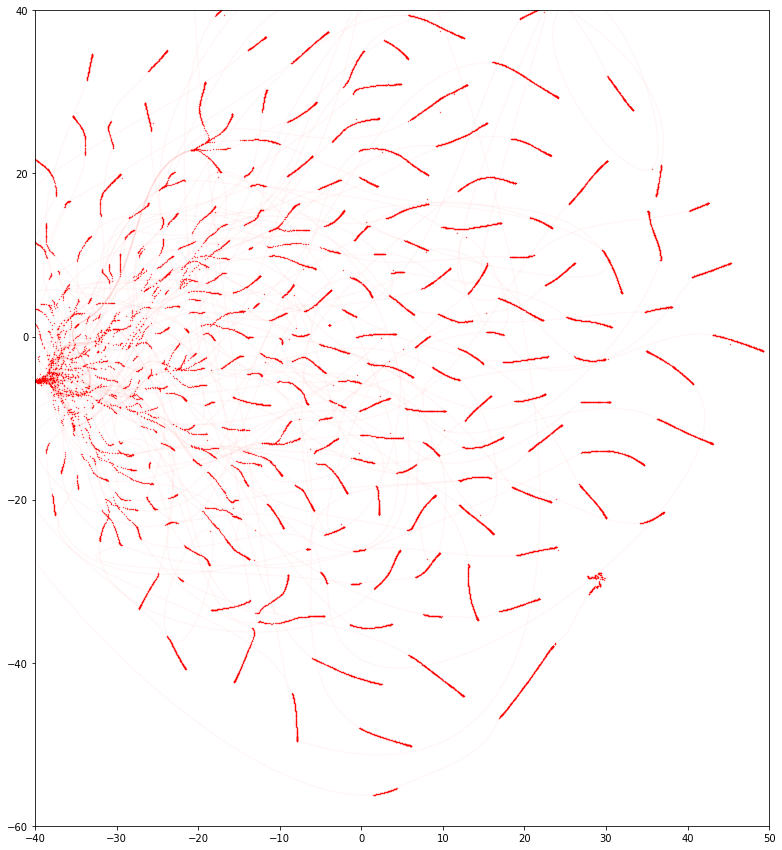

In [65]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.set_aspect(1)
for game in embedding_split:
    tck, u = interpolate.splprep(game.transpose(), s=0)
    unew = np.arange(0, 1.01, 0.01)
    out = interpolate.splev(unew, tck)
    ax.plot(out[0], out[1], '-r', alpha=0.03, color='red')
    ax.scatter(game[:,0], game[:,1], s=0.1, color='red')
#for game in embedding_split[10:800]:
#    tck, u = interpolate.splprep(game.transpose(), s=0)
#    unew = np.arange(0, 1.01, 0.01)
#    out = interpolate.splev(unew, tck)
#    ax.plot(out[0], out[1], '-r', alpha=0.03, color='blue')
#    ax.scatter(game[:,0], game[:,1], s=0.1, color='blue')
plt.xlim((-40,50));
plt.ylim((-60,40));
#for game in embedding_split[100:]:
#    ax.plot(game[:,0], game[:,1], '-r', alpha=0.1, color='blue')

In [66]:
csv = open("gotest.csv", "w")
csv.write("x,y,line,algo")
for x in range(0, 19):
    for y in range(0, 19):
        key = chr(ord('a') + x) + chr(ord('a') + y)
        csv.write(',')
        csv.write(key)
csv.write("\n")
idx = 0

print(len(embedding))
print(len(games))
print(len(games[0].nodes))


for i, game in enumerate(games):
    for state in game.nodes:
        
        csv.write(str(embedding[idx][0]))
        csv.write(',')
        csv.write(str(embedding[idx][1]))
        csv.write(',')
        csv.write(game.line)
        csv.write(',')
        csv.write(game.algo)
        idx = idx + 1
        for fa in state:
            csv.write(',')
            csv.write(str(fa))
        csv.write('\n')
        
csv.close()

21783
100
265
